<a href="https://colab.research.google.com/github/mkorlyakova/Segment-Bio/blob/main/Copy_of_Untitled9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача сегментации пользовательского слайда 
 - пример содержит одновременно кадр исходного изображения и кадр разметки
 - обучения на малой выборке (5 картинок/разметок)

Основная идея: разделить на подкадры + сделать аугментацию

Создадим сеть на основе претренированной модели VGG16 (Imagenet - там похожие по смыслу картинки при обучении)

Грузим VGG16 и определяем список слоев для работы :
loss - cross-entropy metric - DICE coeff. (https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2#:~:text=3.-,Dice%20Coefficient%20(F1%20Score),of%20union%20in%20section%202).)


Смотрим на схему сжатия и не идем дальше 25х25 (нужно будет переделать на нормальные размеры типа 256х1024 - при чтении исходных кадров, тогда можно сжимать до 2х2 :))
- отделяю выход 13-го слоя, для работы в моей сети
- все слои замораживаю (все 18 слоев)
- От последнего рабочего слоя VGG16 (block4_conv3 (Conv2D)) ,буду надстраивать свою сеть

- При обучении используем размер тензоров (,200, 200, 3)(,200,200,14).

- После обучения перестраиваю сеть на размер (,200, 600, 3)(,200,600,14) .

Это позволяет работать с любой картинкой нужного размера, а учить на меньших объектах, экономим память и время обработки, повышаем разнообразие в каждом пакекте (для медицинских фоток типа гистологий работает отлично, тут похуже).

# **Импорт и инсталяция необходимого окружения**
Грузим модули

In [2]:
# Requires the latest pip
!pip install --upgrade pip

# Current stable release for CPU and GPU
!pip install tensorflow

# Or try the preview build (unstable)
!pip install tf-nightly

     |████████████████████████████████| 1.5MB 7.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 400.1 MB 25 kB/s 
     |████████████████████████████████| 4.0 MB 74.6 MB/s 
     |████████████████████████████████| 4.0 MB 67.7 MB/s 
     |████████████████████████████████| 12.2 MB 255 kB/s 
     |████████████████████████████████| 462 kB 74.6 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [34]:
import random
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.io import imread, imshow, concatenate_images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage.color
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from keras import backend as K
from PIL import Image
import tensorflow
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers  import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


In [10]:
from glob import glob


In [9]:

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

Загружаем картинки для сегментации :

половина - это сам кадр, 
вторая половина - это разметка

In [5]:
URL_GIT = 'https://github.com/mkorlyakova/Segment-Bio.git'

In [6]:
!git clone -l -s https://github.com/mkorlyakova/Segment-Bio.git cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [7]:
path='.'
files_name=os.listdir(path)

In [12]:
I=  glob('*.JPG')+  glob('*.jpg') +  glob('*.jpeg')
I

['29-18-0002-2.JPG', '28-18-0002.JPG', '29-18-0002-1.JPG', '31-18-0001.jpg']

In [13]:
def block_seg(I_seg=None,I_org=None, I_lab=None ,w=50, dw=10):
  S=I_seg.shape
  #print(S)
  k=np.random.randint(w,S[1]-w*2)
  m=np.random.randint(w,S[0]-w*2)
  Ib_segment=I_seg[m:m+w*2,k-dw:k+w*2-dw]
  I_lab_=I_lab[m:m+w*2,k-dw:k+w*2-dw]
  Ib_org=I_org[m:m+w*2,k:k+w*2]
  return Ib_org,Ib_segment, I_lab_
       
             

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


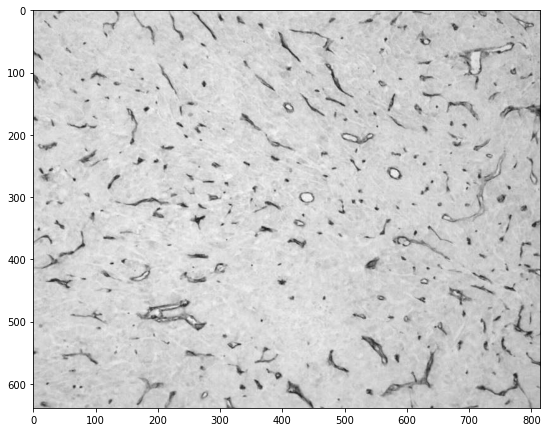

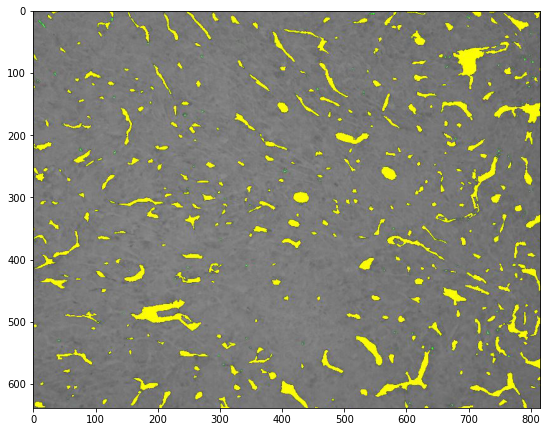

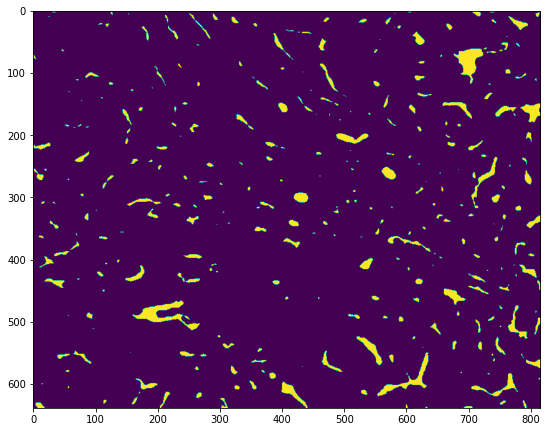

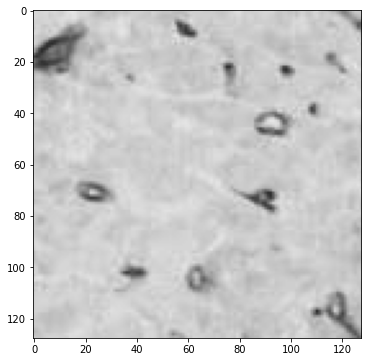

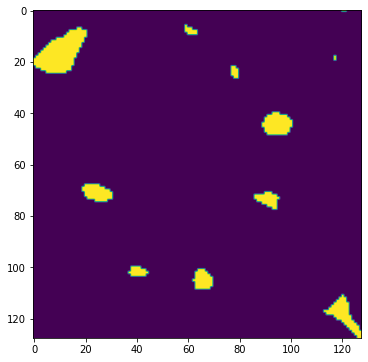

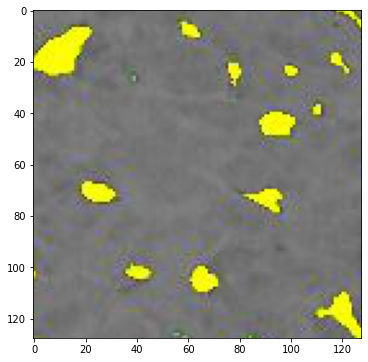

In [14]:
p10 = 150
step_w=35
ImageOrig=[]
ImageLable=[]
image_input=[]
image_segment=[]
image_label=[]
ImageLabUser=[]
image_I=[]
parSegment = 100
w = 64
th=0.8
#th=0.9
kerner_rad = 1

gause_rad = 9

max_val=1
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kerner_rad,kerner_rad))
p1_=[]
for i in I:
  path_file_i =path+'/'+i
  A=mpimg.imread(path_file_i, format='jpg')
  n_split =A.shape[1]//2

  I_org = A[step_w:-step_w-9,step_w:n_split-4-step_w-42,:]
  I_org = I_org.astype('float32')/ np.max(I_org);
  
  I_lab = A[step_w:-step_w-9,n_split+5+step_w:-step_w-41,:]
  I_lab = I_lab.astype('float32')/ np.max(I_lab)

  p10_s = np.sum(np.abs(I_lab[:,:,0]-I_lab[:,:,2]))
  p10s = np.sum(np.abs(I_lab[:,:,0]-I_lab[:,:,1]))
 
  p10_ = np.mean(np.abs(I_lab[:,:,0]-I_lab[:,:,2]))*20.5 
  p10 = np.mean(np.abs(I_lab[:,:,0]-I_lab[:,:,1]))*20.5
  p1_.append([i, str(p10),str(p10_), str(p10_s), str(p10s)])
  
  I1=np.abs(I_lab[:,:,0]-I_lab[:,:,1])>p10
  I2=np.abs(I_lab[:,:,0]-I_lab[:,:,2])>p10_
  I3=np.abs(I_lab[:,:,1]-I_lab[:,:,2])>p10
  IL=np.array([I1 | I2 | I3 ]).astype('float32')
  Is=IL.shape
  IL=IL.reshape((Is[1],Is[2]))
  IL = cv2.GaussianBlur(IL, (gause_rad, gause_rad), 0)
  IL = np.array(cv2.threshold(IL,th,max_val,cv2.THRESH_BINARY))[1]
  IL= cv2.dilate(IL, kernel, iterations = 1)
  ImageLabUser.append(I_lab.copy())
  ImageOrig.append(I_org.copy())
  ImageLable.append(IL.copy())
  
  for j in range(parSegment):
    Ioi,Isi,Ili=block_seg(IL,I_org, I_lab,w) 
    if np.sum(Isi)>50:
      image_input.append(Ioi.copy())
      image_segment.append(Isi.copy())
      image_label.append(Ili.copy())
      image_I.append([i])

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(I_org)

A.shape

plt.figure(figsize=(20,20))
plt.subplot(1,2,2)
plt.imshow(I_lab)
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(IL)


plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(Ioi)


plt.figure(figsize=(20,20))
plt.subplot(1,3,2)
plt.imshow(Isi)

plt.figure(figsize=(20,20))
plt.subplot(1,3,3)
plt.imshow(Ili)
plt.show()

#plt.figure(figsize=(20,20))
#plt.subplot(1,3,3)
#plt.imshow([i])
#plt.show()

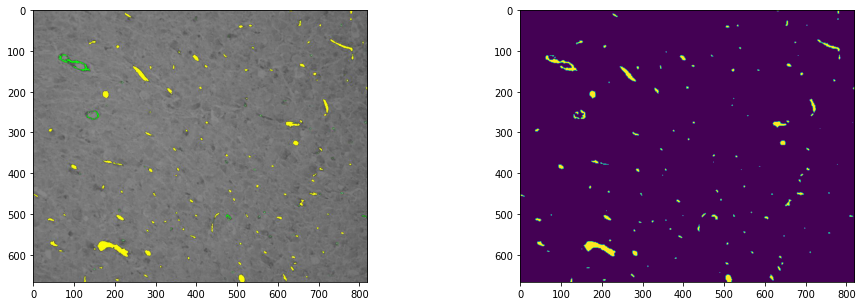

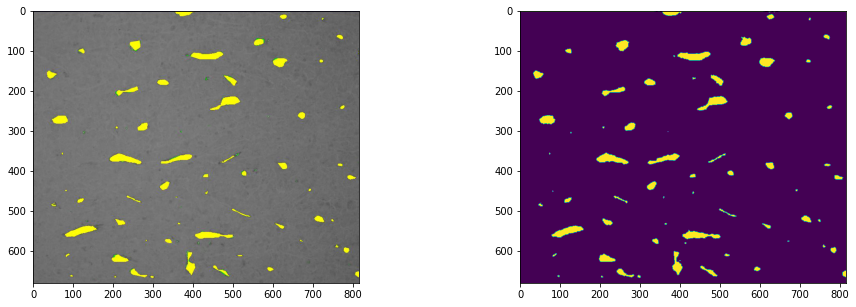

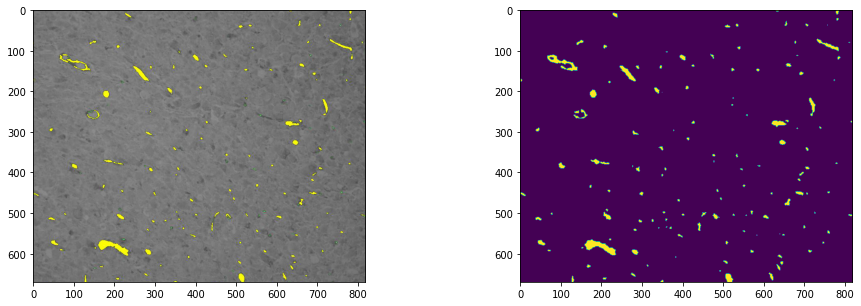

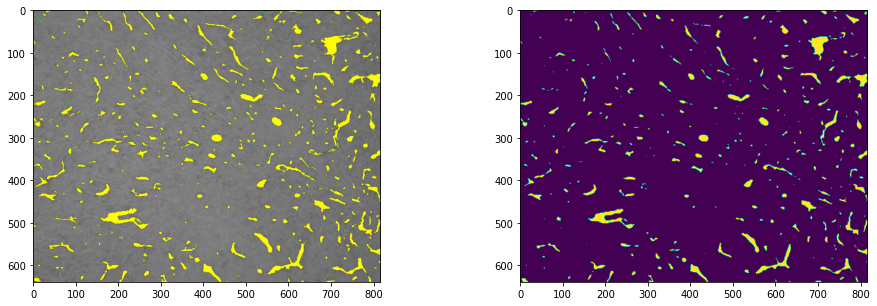

In [15]:
for i in range(len(ImageLabUser)):
  plt.figure(figsize=(16,5))
  plt.subplot(1,2,1)
  plt.imshow(ImageLabUser[i])            
  plt.subplot(1,2,2)
  plt.imshow(ImageLable[i]) 

plt.show()

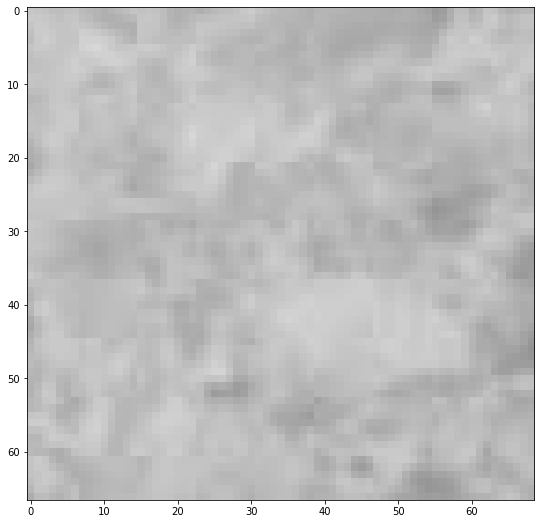

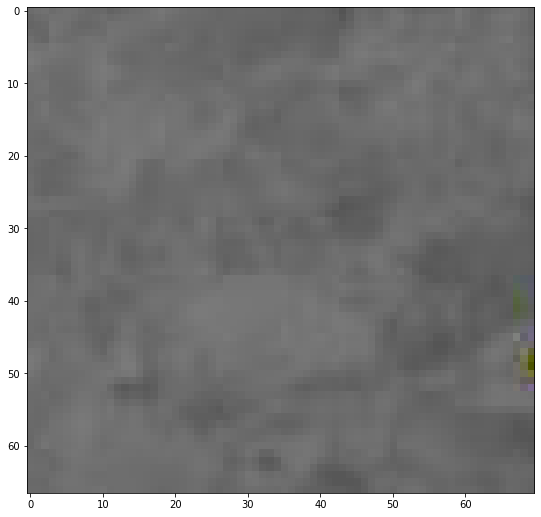

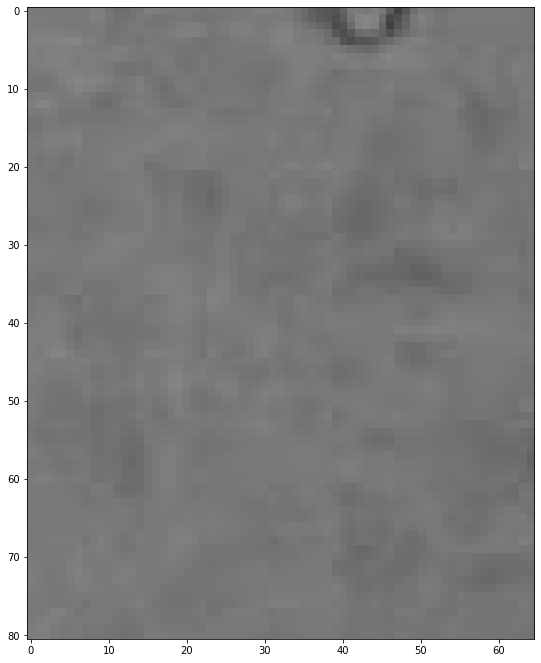

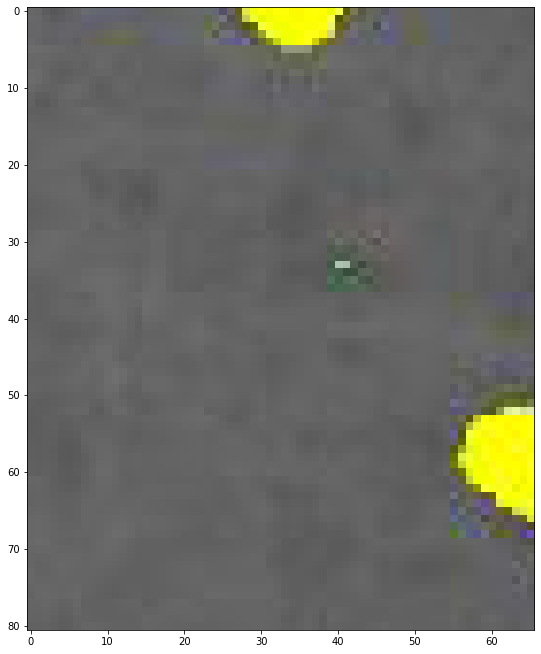

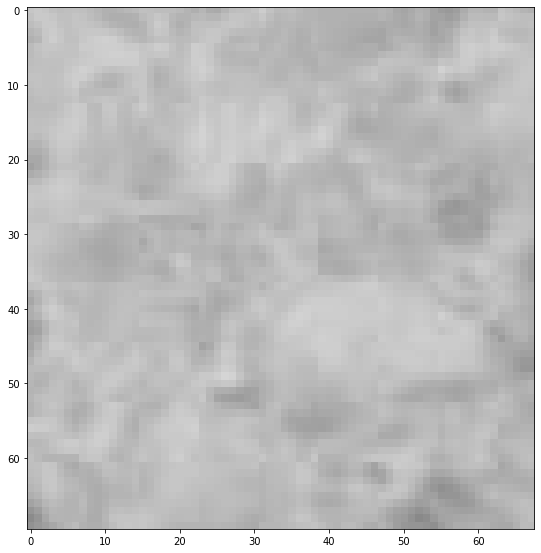

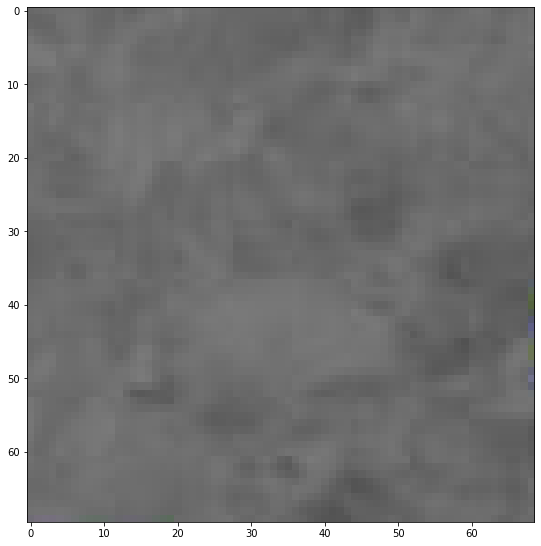

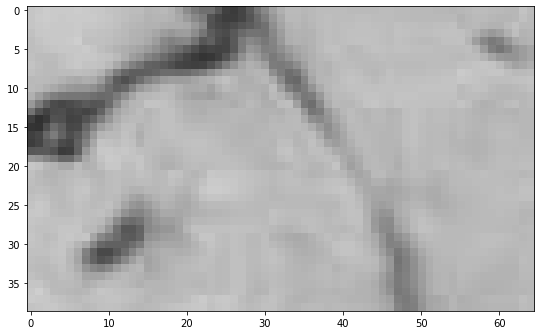

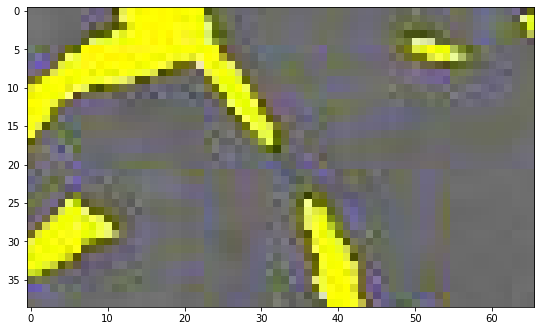

In [16]:
for i in I:
  path_file_i =path+'/'+i
  A=mpimg.imread(path_file_i, format='jpg')
  n_split =A.shape[1]//2

  I_org = A[step_w:-step_w-9,step_w:n_split-4-step_w-42,:]
  I_org = I_org.astype('float32')/ np.max(I_org)
  I_lab = A[step_w:-step_w-9,n_split+5+step_w:-step_w-41,:]
  I_lab = I_lab.astype('float32')/ np.max(I_lab)


  plt.figure(figsize=(20,20))
  plt.subplot(1,2,1)
  plt.imshow(I_org[600:,750:,:])



  plt.figure(figsize=(20,20))
  plt.subplot(1,2,2)
  plt.imshow(I_lab[600:,750:,:])
  plt.show()

In [17]:
len(image_segment)


382

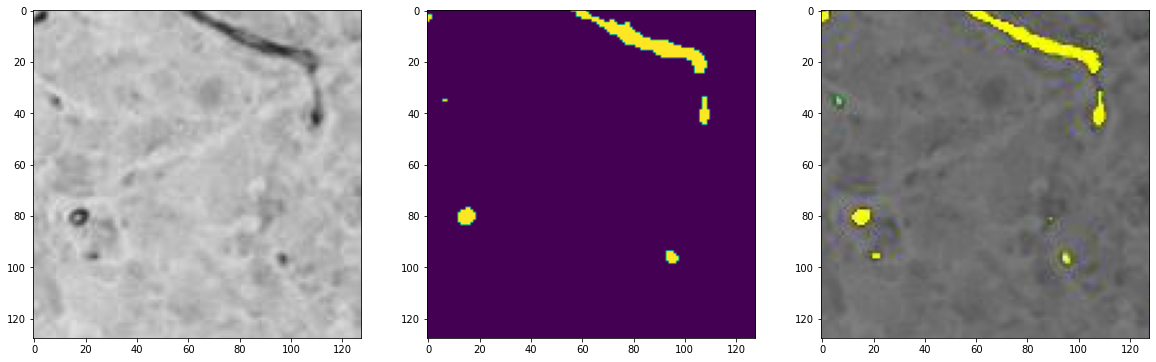

In [18]:
n=30
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(image_input[n][:,:,:])


plt.subplot(1,3,2)
plt.imshow(image_segment[n][:,:])

plt.subplot(1,3,3)
plt.imshow(image_label[n][:,:])
plt.show()

#plt.figure(figsize=(10,10))
#plt.subplot(1,2,1)
#plt.imshow(image_I[1][:,:])
#plt.show()

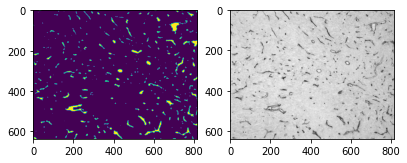

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(ImageLable[3][:,:])

plt.subplot(1,3,2)
plt.imshow(ImageOrig[3])

plt.show()

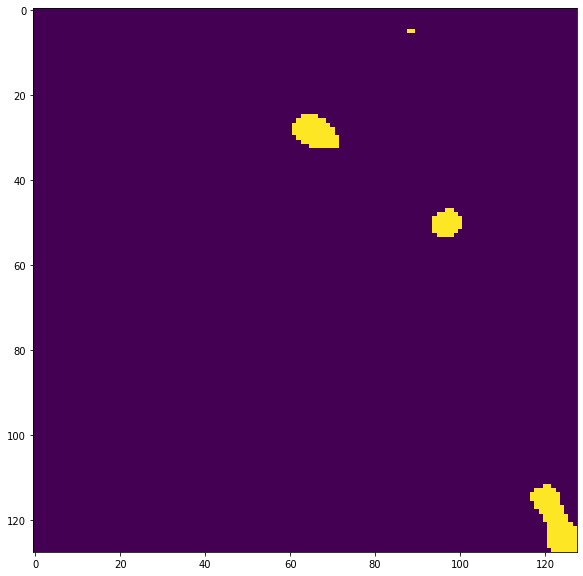

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(image_segment[3].astype('int'))
plt.show()

In [21]:
image_segment[3].min()

0.0

In [22]:
image_input=np.array(image_input)
image_segment = np.array(image_segment)
N_split = -10


xTrain = []

for img in image_input[:N_split,:,:,:]:
  x = image.img_to_array(img)
  xTrain.append(x)

xTrain = np.array(xTrain)

In [23]:
xTrain.shape

(372, 128, 128, 3)

In [24]:
xTest = []

for img in image_input[N_split:,:,:,:]:
  x = image.img_to_array(img)
  xTest.append(x)

xTest = np.array(xTest)

In [25]:
yTrain = []

for seg in image_segment[:N_split,:,:]:
  y = image.img_to_array(seg)
  yTrain.append(y[:,:].reshape(( 2*w, 2*w,1)))

yTrain = np.array(yTrain)

In [26]:
yTrain.shape

(372, 128, 128, 1)

In [27]:
yTrain[0,:,:,:].max()

1.0

In [28]:
yTest = []

for seg in image_segment[N_split:,:,:]:
  y = image.img_to_array(seg)
  yTest.append(y[:,:,0].reshape(( 2*w, 2*w,1)))

yTest = np.array(yTest)

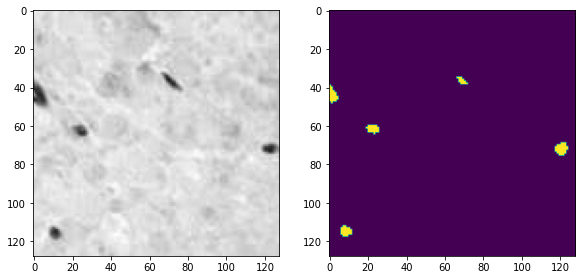

In [29]:
i_t=xTrain[0,:,:,:]
In=np.array(i_t)
Itest=(yTrain[0,:,:]).astype('int')

plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(i_t/np.max(i_t))
plt.subplot(1,3,2)

plt.imshow(Itest.reshape((2*w,2*w)))
plt.show()

In [30]:
def Nounet(num_classes = 1, input_shape= (2*w,2*w, 3), list_kernel=[100,328], lr=0.0001,b1 = 0.9, b2=0.9999):
  
     
    img_input = tensorflow.keras.layers.Input(input_shape)

    # Block 1
    x = Conv2D(list_kernel[0], (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(list_kernel[0], (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(list_kernel[1], (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(list_kernel[1], (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

  

    # UP 1
    x = Conv2DTranspose(list_kernel[1], (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(list_kernel[1], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(list_kernel[1], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(list_kernel[0], (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(list_kernel[0], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(list_kernel[0], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=lr, beta_1=b1, beta_2=b2),
                  loss = 'mse',
                  #loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  #loss=dice_coef,    #'binary_crossentropy',
                  metrics=[dice_coef])
    #model.summary()
    model.summary()
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

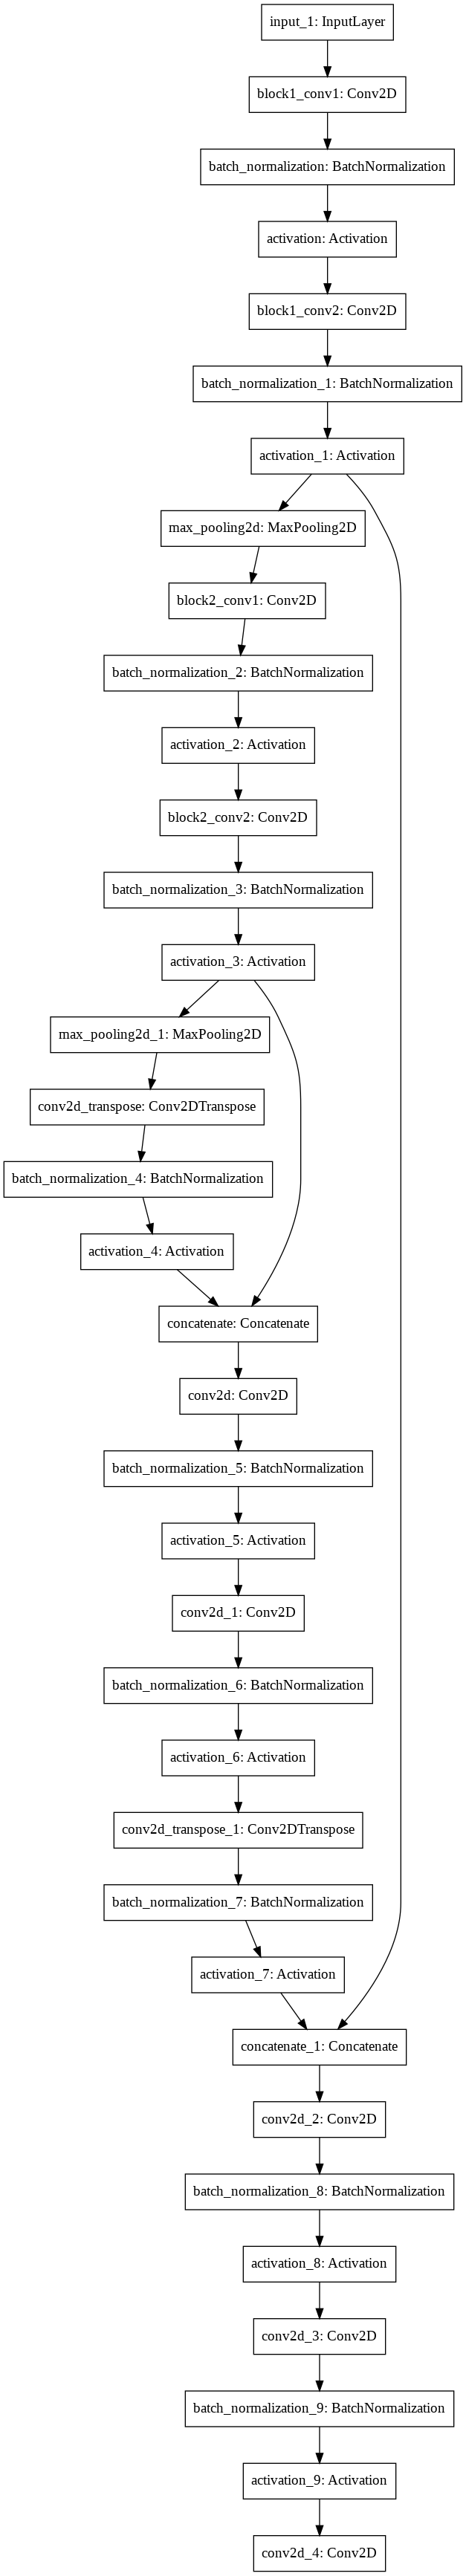

In [31]:
im_size=xTrain[0].shape
model = Nounet(1, (im_size[0],im_size[1], 3),list_kernel=[64,128],lr=0.0001,b1 = 0.9, b2=0.9999)
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')



In [32]:
im_size

(128, 128, 3)

In [41]:
def unet_pre_train(num_classes = 13, input_shape= (200, 200, 3), lr=0.0001,b1 = 0.9, b2=0.9999):  
    # грузим   VGG16
    pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    # замораживаем все слои
    for layer in pre_trained_model.layers[:18]:
      layer.trainable = False
    # фиксируем последний рабочий слой для своего потока  
    x = pre_trained_model.layers[13].output
    # фиксируем скипы для переноса из VGG16 (надо еще проверять)
    block_4_out = pre_trained_model.layers[10].output
    block_3_out = pre_trained_model.layers[6].output
    block_2_out = pre_trained_model.layers[3].output
    #  фиксируем вход сети
    img_input = pre_trained_model.inputs

    # задаем список скипов 
    blocks = [block_4_out, block_3_out, block_2_out]
    #print(block_4_out)
    #print(block_3_out)
    #print(block_2_out)
    # UP 1

    
    for i in [0,1,2]:
      x = concatenate([x, blocks[i]]) # добавили перенос из понижаюшего плеча VGG16
      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(256, (3, 3), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      # UP i
      x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

    
    # последний слой сверток для классификации
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if num_classes>1:
      x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(),
                    loss='categorical_crossentropy',
                    metrics=[dice_coef])
    else:
      x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
      # собираем модель 
      model = Model(img_input, x)
      model.compile(optimizer=Adam(learning_rate=lr, beta_1=b1, beta_2=b2),
                    loss = 'mse',
                    metrics=[dice_coef])

    model.summary()
    # вернем модель
    return model

**Претренированная Unet**

Грузим VGG16 и определяем список слоев для работы :

- смотрим на схему сжатия и не идем дальше нечетных размеров (нужно брать на нормальные размеры типа 256х256 - при чтении исходных кадров, тогда можно сжимать до 2х2 :))
- отделяю выход 13-го слоя, для работы в моей сети
все слои замораживаю (все 18 слоев)
- от последнего рабочего слоя VGG16 (block4_conv3 (Conv2D)) ,буду надстраивать свою сеть
- при обучении используем размер тензоров (,128, 128, 3)(,128,128,1)
- после обучения перестраиваю сеть на размер (,600, 600, 3)(,600,600,1) . Это позволяет работать с любой картинкой нужного размера, а учить на меньших объектах, экономим память и время обработки, повышаем разнообразие в каждом пакекте - для медицинских фоток типа гистологий работает отлично.

In [42]:

model= unet_pre_train(num_classes = 1, input_shape= (128, 128, 3))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:

history = model.fit(xTrain, yTrain, epochs=30, batch_size=64, validation_data=(xTest, yTest))

Epoch 1/30
6/6 [==============================] - 498s 82s/step - loss: 0.3244 - dice_coef: 0.0779 - val_loss: 0.6965 - val_dice_coef: 0.0866
Epoch 2/30
1/6 [====>.........................] - ETA: 7:00 - loss: 0.1914 - dice_coef: 0.1076

In [33]:
history=model.fit(xTrain,yTrain,batch_size=10,epochs=10,validation_split=0.1)
model.save_weights('zaw.hdf5')


Epoch 1/10
34/34 [==============================] - 229s 7s/step - loss: 0.2384 - dice_coef: 0.1074 - val_loss: 0.1950 - val_dice_coef: 0.0784
Epoch 2/10
18/34 [==============>...............] - ETA: 1:45 - loss: 0.0690 - dice_coef: 0.1782

KeyboardInterrupt: ignored

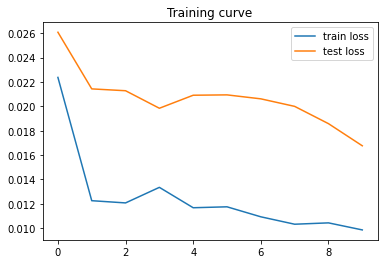

In [ ]:
plt.plot(history.history['loss'],label = 'train loss')
plt.plot(history.history['val_loss'],label = 'test loss')
plt.legend()
plt.title('Training curve')
plt.show()

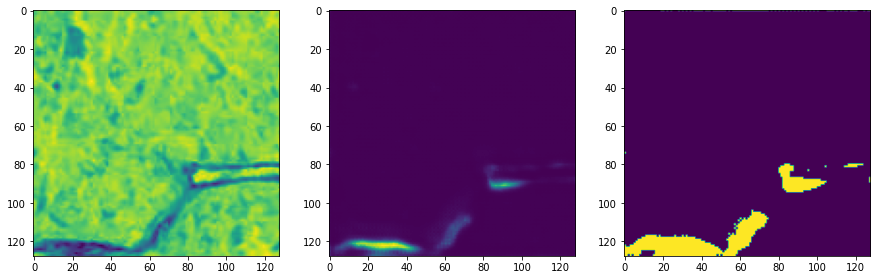

In [ ]:
n=0

i_t=xTrain[n,:,:,0]
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(i_t/np.max(i_t))

In=np.array(i_t)
Itest=model.predict(xTrain[:1,:,:,:])
plt.subplot(1,3,2)
plt.imshow(Itest[0].reshape((2*w,2*w))/np.max(Itest[0,:,:,0]))
plt.subplot(1,3,3)
plt.imshow((Itest[0,:,:,0]>(Itest.mean()*2)).astype(float))
plt.show()

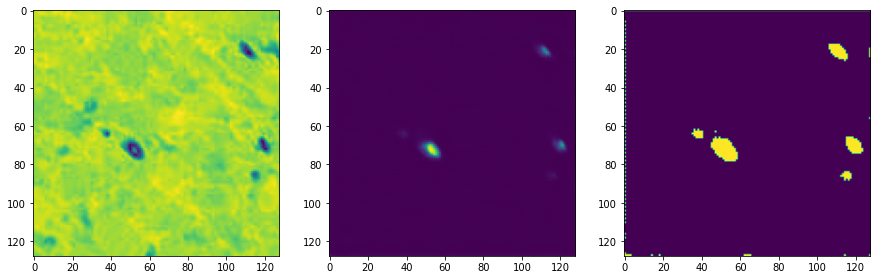

In [ ]:
n=0

i_t=xTest[n,:,:,0]
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(i_t/np.max(i_t))

In=np.array(i_t)
Itest=model.predict(xTest[:1,:,:,:])
plt.subplot(1,3,2)
plt.imshow(Itest[0].reshape((2*w,2*w))/np.max(Itest[0,:,:,0]))
plt.subplot(1,3,3)
plt.imshow((Itest[0,:,:,0]>(Itest.mean()*2)).astype(float))
plt.show()

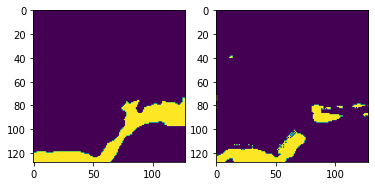

In [ ]:
n = 0
plt.subplot(1,2,1)
plt.imshow(np.array(image_segment[n]).astype('int')*255)

plt.subplot(1,2,2)
img = np.array(Itest[0,:,:,0]>Itest[0,:,:,0].mean()*1.5) 
plt.imshow((img*255).astype('int'))
plt.show()

Большая сеть!!!


Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 656, 816, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 656, 816, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 656, 816, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_70 (Activation)      (None, 656, 816, 64) 0           batch_normalization_70[0][0]     
______________________________________________________________________________________

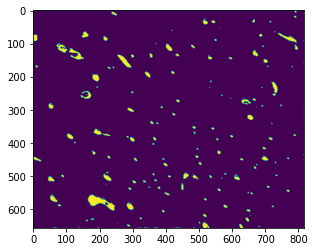

In [ ]:
im_size=I_org.shape
im_size_k=np.array(im_size) % 8
I_org=I_org[:im_size[0]-im_size_k[0],:im_size[1]-im_size_k[1],:]
#im_size=I_org.shape
#im_size_k=np.array(im_size)%8


Modelbeak = Nounet(1, (im_size[0],im_size[1], 3),list_kernel=[64,128])
from tensorflow.keras.utils import plot_model
plot_model(Modelbeak, to_file='model.png')
Modelbeak.load_weights('zaw.hdf5')

Is=Modelbeak.predict(I_org.reshape((1,im_size[0],im_size[1],im_size[2])))

Is =Is[:,:,:,:]>(Is.mean()*1.5)
plt.imshow(Is[0,:,:,0].astype(float))


#plt.imshow(Is[0].reshape((2*w,2*w))/np.max(Is[0])*255)

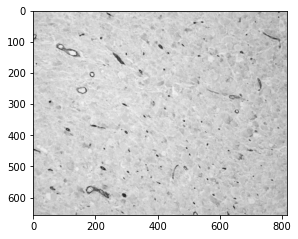

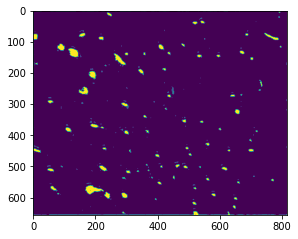

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(I_org)

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.imshow(Is[0,:,:,0])